# Analysis - Suspicious activities detection

In this notebook, we analyse the recorded events from an online advertiser to detect fraudulent activites. 
More than 2 hours of activites has been recorded in order to identify 3 suspicous patterns.
Analysis are based on the Click-through-rate (CTR) to validate/invalidate a normal sequence of activites. 

We consider a normal CTR to be around **10%.** 

## Methodology

We are going to use 2 datasets :
* a dev set where we will identify suspicious partterns, 
* a test set where we will see how the evolution of the CTR is affected after removing the suspicious pattern found from the dev set to check if we still have a CTR of 10%.

## Analysing patterns

### Baseline

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

import os
import json

plt.style.use('ggplot')

In [43]:
# Import file
filename = "../quickstart/data/logs_100_000.txt"
assert os.path.exists(filename)

cols = ['eventType', 'uid', 'timestamp', 'ip', 'impressionId']

# read file
def read_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data = {col: [] for col in cols}
    for json_line in lines:
        dline = json.loads(json_line)
        for col in cols:
            data[col].append(dline[col])
    return data

def import_data(filename):
    data = read_file(filename)
    df = pd.DataFrame(data)

    # handle dates
    df["timestamp"] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d %H-%M-%S"))
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H-%M-%S')

    # Print stats
    # Min max date
    print('------------Stats on imported dataset-------------')
    print(f"shape : {df.shape}")
    min_time = df.timestamp.min()
    max_time = df.timestamp.max()
    num_mins = (max_time - min_time).total_seconds() / 60.0

    print(f"Min timestamp : {min_time}")
    print(f"Max timestamp : {max_time}")
    print(f'Delta : {max_time - min_time}')
    print('---------------------------------------------------')
    
    return df

df = import_data(filename)

------------Stats on imported dataset-------------
shape : (165141, 5)
Min timestamp : 2021-05-15 13:05:34
Max timestamp : 2021-05-15 15:32:02
Delta : 0 days 02:26:28
---------------------------------------------------


#### Parameters

* We have recorded 2 hours and 26 minutes of activities.
* We chose a time window of 10 minutes.

In [44]:
WINDOW_SIZE = 10

In [45]:
def apply_windowing(df, num_min=10):
    min_time = df.timestamp.min()
    max_time = df.timestamp.max()
    delta = timedelta(minutes=num_min)  # Window size in minutes
    start_time = min_time
    end_time = min_time + delta
    bins = [0]
    while start_time < max_time:
        bins.append((end_time-min_time).total_seconds())
        start_time += delta
        end_time += delta
    df['time_bucket'] = df.timestamp.apply(lambda x: np.digitize((x-min_time).total_seconds(), bins))
    df = df[df['time_bucket'] != df.time_bucket.max()].copy()
    return df

df = apply_windowing(df, num_min=WINDOW_SIZE)

CTR : 32.7533% | #clicks=38928 ; #displays=118852
None


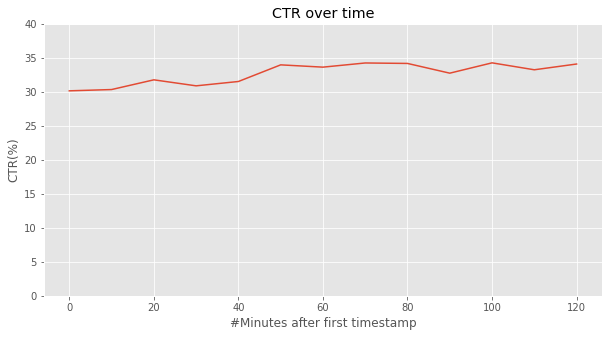

In [46]:
def CTR(df, returned=False, silent=False, meta=False):
    num_clicks = (df['eventType'] == 'click').sum()
    num_displays = (df['eventType'] == 'display').sum()
    ctr = round(100 * num_clicks / num_displays, 4)
    if not silent:
        print(f'CTR : {ctr}% | #clicks={num_clicks} ; #displays={num_displays}')
    if meta:
        return ctr, num_clicks, num_displays
    if returned:
        return ctr
    
    
def CTR_by_window(df, window_size, plot=True):
    delta = timedelta(minutes=window_size)
    start_time = df.timestamp.min()
    end_time = start_time + delta
    max_time = df.timestamp.max()
    ctrs, clicks, displays =  [], [], []
    while end_time < max_time:
        chunk_df = df[(df.timestamp < end_time) & (df.timestamp > start_time)]
        ctr, num_clicks, num_displays = CTR(chunk_df, returned=True, silent=True, meta=True)
        start_time += delta
        end_time += delta
        ctrs.append(ctr)
        clicks.append(num_clicks)
        displays.append(num_displays)
    if plot:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(range(0, len(ctrs)*window_size, window_size), ctrs)
        ax.set_ylim(0, 40)
        ax.set_title('CTR over time')
        ax.set_ylabel('CTR(%)')
        ax.set_xlabel('#Minutes after first timestamp');
    else:
        return ctrs, clicks, displays

_ = print(CTR(df))
CTR_by_window(df, 10);

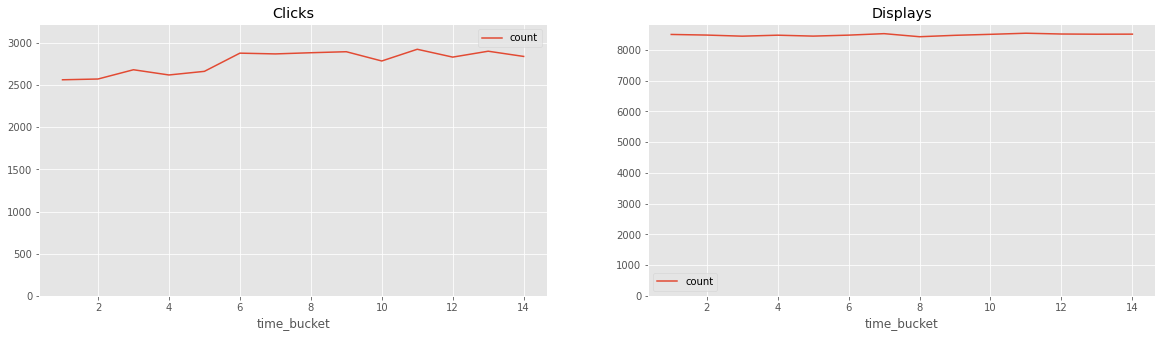

In [47]:
def plot_click_display(df):
    type_counts = df.groupby(['time_bucket', 'eventType']).count().reset_index()[['time_bucket', 'eventType', 'uid']].rename({'uid': 'count'}, axis=1)

    _, ax = plt.subplots(1, 2, figsize=(20, 5))
    clicks = type_counts[type_counts.eventType == 'click']
    displays = type_counts[type_counts.eventType == 'display']
    clicks.plot(kind='line', x='time_bucket', y='count', ax=ax[0])
    displays.plot(kind='line', x='time_bucket', y='count', ax=ax[1])
    
    max_nclicks = clicks['count'].max() + 300
    max_ndisplays = displays['count'].max() + 300
    ax[0].set_title('Clicks'), ax[0].set_ylim(0, max_nclicks)
    ax[1].set_title('Displays'), ax[1].set_ylim(0, max_ndisplays);
    
plot_click_display(df)

#### Insights

* CTR is around 30% over the entire period of time.
* The number of clicks increases after 50 minutes (~14PM) while the number of displays remains constant.

### Pattern 1

In [48]:
def get_ip_view(df):
    ips = df.groupby(['ip', 'time_bucket']).agg({'uid':list, 'eventType':list}).reset_index()
    ips['num_events'] = ips.eventType.apply(lambda x: len(x))
    ips['num_uids'] = ips.uid.apply(lambda x: len(set(x)))
    ips['num_clicks'] = ips.eventType.apply(lambda x: x.count('click'))
    return ips

In [49]:
ips = get_ip_view(df)

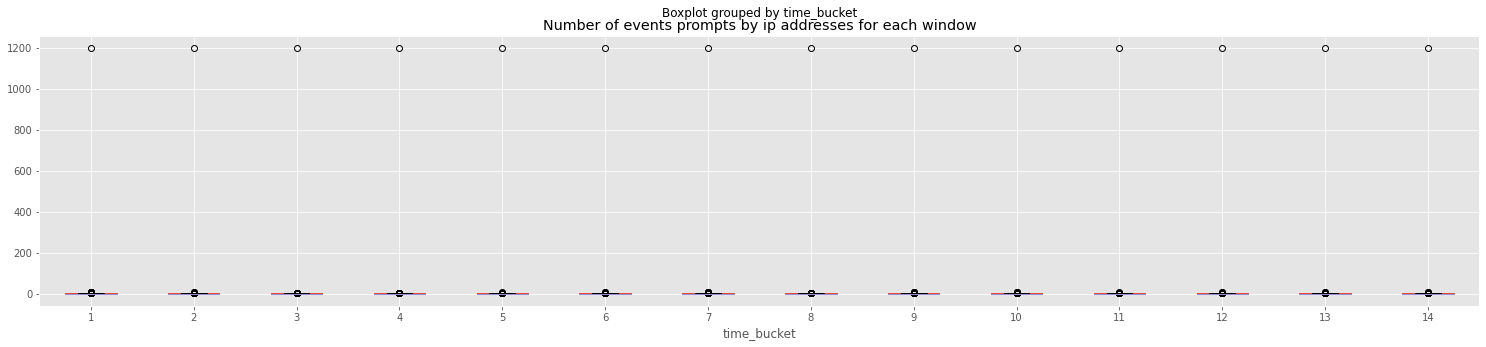

In [50]:
_, ax = plt.subplots(1, 1, figsize=(25, 5))
ips.boxplot(column='num_events', by="time_bucket", ax=ax)
ax.set_title('Number of events prompts by ip addresses for each window');

In [51]:
ips.sort_values(['num_events', 'time_bucket'], ascending=False)[['ip', 'num_events', 'num_uids', 'num_clicks']].head(14)

,ip,num_events,num_uids,num_clicks
53442,238.186.83.58,1200,600,600
53441,238.186.83.58,1200,600,600
53440,238.186.83.58,1200,600,600
53439,238.186.83.58,1200,600,600
53438,238.186.83.58,1200,600,600
53437,238.186.83.58,1200,600,600
53436,238.186.83.58,1200,600,600
53435,238.186.83.58,1200,600,600
53434,238.186.83.58,1200,600,600
53433,238.186.83.58,1200,600,600


#### Insights

* One ip address have been responsible of 1200 events and 600 clicks in each window. 
* It is also associated with 600 uids.


In [52]:
def remove_ip_count_too_high(df, ip_view=None):
    if ip_view is None:
        ip_view = get_ip_view(df)
    df = df.merge(ip_view[['ip', 'time_bucket', 'num_events']], on=['ip', 'time_bucket'], how='left')
    df_clean = df[df.num_events < 10].copy()
    return df_clean


df_clean = remove_ip_count_too_high(df)
CTR(df_clean)

CTR : 27.6392% | #clicks=30528 ; #displays=110452


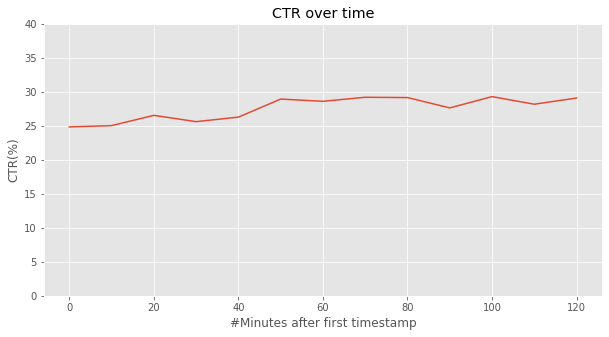

In [53]:
CTR_by_window(df_clean, WINDOW_SIZE, plot=True)

#### Results

* The CTR has dropped from 30% to 27%.
* 1 ip address has been removed : 238.186.83.58

### Pattern 2

In [55]:
def reaction_time(x):
    history = sorted([(t, event, ip, imp_id) for t, event, ip, imp_id in zip(x['timestamps'], x['events'], x['ip'], x['impressionId'])])
    deltas = []
    for i in range(1, len(history)):
        if history[i][1] == 'click':
            for j in range(0, i):
                if history[j][1] == 'display' and history[i][2] == history[j][2] and history[i][3] == history[j][3]:
                    delta = (history[i][0] - history[j][0]).total_seconds()
                    deltas.append(delta)
                    break
    return deltas


def get_time_reaction_uid_view(df_clean):
    uids = (df_clean
            .groupby(['uid', 'time_bucket'])
            .agg({'eventType':list, 'timestamp':list, 'impressionId':list, 'ip':list})
            .rename({'eventType':'events', 'timestamp':'timestamps'}, axis=1)
            .reset_index()
           )

    uids['reaction_times'] = uids.apply(lambda x: reaction_time(x), axis=1)
    uids['num_events'] = uids['events'].apply(lambda x: len(x))
    uids['min_reaction_time'] = uids.reaction_times.apply(lambda x: min(x) if len(x) > 0 else None)
    uids['avg_reaction_time'] = uids.reaction_times.apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
    return uids

uids = get_time_reaction_uid_view(df_clean)

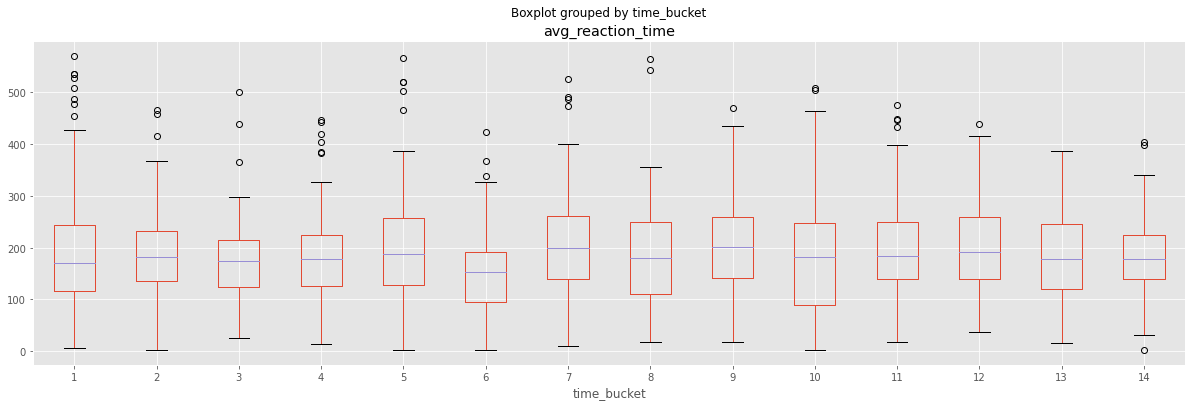

In [56]:
uids.boxplot(column='avg_reaction_time', by='time_bucket', figsize=(20, 6));

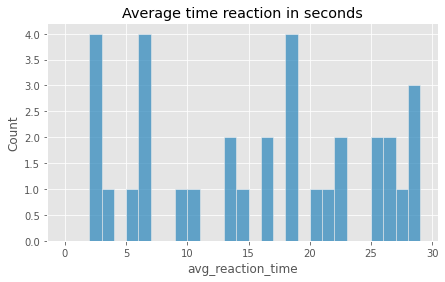

In [57]:
_, ax = plt.subplots(1, 1, figsize=(7, 4))
sns.histplot(uids.avg_reaction_time, bins=np.arange(0, 30, 1), ax=ax)
ax.set_title("Average time reaction in seconds");

#### Insights

* The median average time reaction to click on an advertisement once it has been displayed is between 100 and 200 seconds (2-3 minutes).
* Some users click in a very short period of time on average (<=3seconds).

In [58]:
def remove_short_reaction_time_uids(df_clean, uid_view=None):
    if uid_view is None:
        uid_view = get_time_reaction_uid_view(df_clean)
    uids_to_remove = set(uid_view[(uid_view.avg_reaction_time <= 3)].uid)
    #print(uids_to_remove)
    df_clean_2 = df_clean[~df_clean.uid.isin(uids_to_remove)].copy()
    return df_clean_2

CTR : 27.4722% | #clicks=30040 ; #displays=109347
None


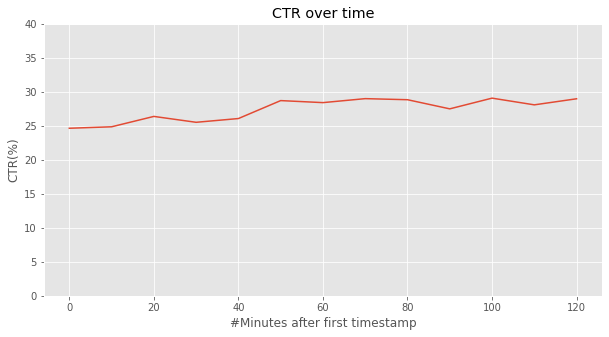

In [59]:
df_clean_2 = remove_short_reaction_time_uids(df_clean)

print(CTR(df_clean_2))
CTR_by_window(df_clean_2, window_size=WINDOW_SIZE)

#### Results

* Small dropped in CTR.
* 4 uids removed.

### Pattern 3

In [60]:
def get_uid_activities_view(df_clean_2):
    uidxctr = df_clean_2.groupby(['time_bucket', 'uid']).agg({'eventType': list, 'impressionId':list, 'ip':list}).reset_index().rename({'eventType':'events'}, axis=1)
    uidxctr['ctr_uid'] = uidxctr.events.apply(lambda x: x.count('click') / max(1, x.count('display') ))
    uidxctr['num_clicks'] = uidxctr.events.apply(lambda x: x.count('click'))
    uidxctr['num_events'] = uidxctr['events'].apply(lambda x: len(x))
    uidxctr["num_ip"] = uidxctr.ip.apply(lambda x: len(set(x)))
    return uidxctr

uidxctr = get_uid_activities_view(df_clean_2)

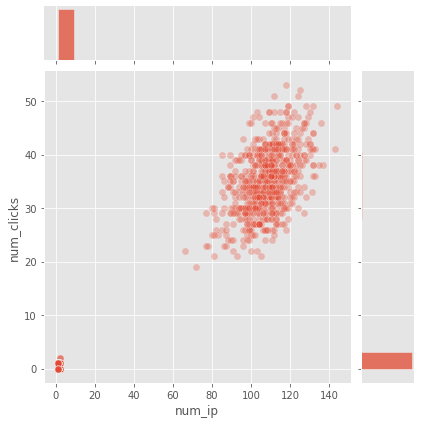

In [61]:
sns.jointplot(x="num_ip", y="num_clicks", data=uidxctr, alpha=0.3, s=50);

#### Insights

* Some users are associated with more than 40 ip addresses and clicks more than 15 times in 10 minutes.
* The majority of users has a small number of ip addresses and clicks.

In [62]:
def remove_uid_with_too_much_activities(df_clean_2, uid_activities_view=None):
    if uid_activities_view is None:
        uid_activites_view = get_uid_activities_view(df_clean_2)
    df_clean_3 = df_clean_2.merge(uid_activites_view[['uid', 'time_bucket', 'num_clicks', 'num_ip']], 
                                  on=['uid', 'time_bucket'], how='left')
    df_clean_3 = df_clean_3[df_clean_3['num_ip'] < 40].copy()
    return df_clean_3

CTR : 10.724% | #clicks=5922 ; #displays=55222
None


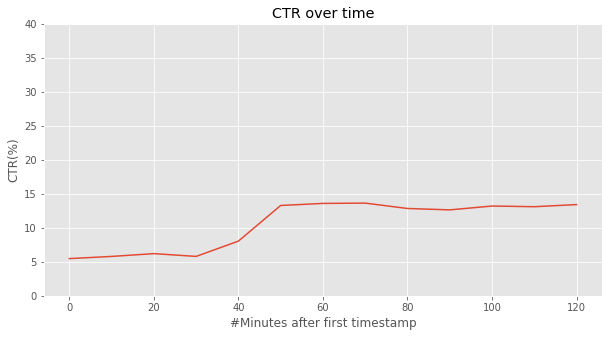

In [63]:
df_clean_3 = remove_uid_with_too_much_activities(df_clean_2)

print(CTR(df_clean_3))
CTR_by_window(df_clean_3, window_size=WINDOW_SIZE)

#### Results

* The CTR is around 10% and can fluctuate between 5% and 15% from a window to another.

## Test on another dataset

In [64]:
testfile = "../quickstart/data/test_50_000.txt"
df_test = import_data(testfile)

df_test = apply_windowing(df_test, num_min=WINDOW_SIZE)

df_test_2 = remove_ip_count_too_high(df_test)
df_test_3 = remove_short_reaction_time_uids(df_test_2)
df_test_4 = remove_uid_with_too_much_activities(df_test_3)

------------Stats on imported dataset-------------
shape : (104824, 5)
Min timestamp : 2021-06-30 14:30:54
Max timestamp : 2021-06-30 16:04:20
Delta : 0 days 01:33:26
---------------------------------------------------


In [65]:
CTR(df_test_4)

CTR : 10.2336% | #clicks=3618 ; #displays=35354


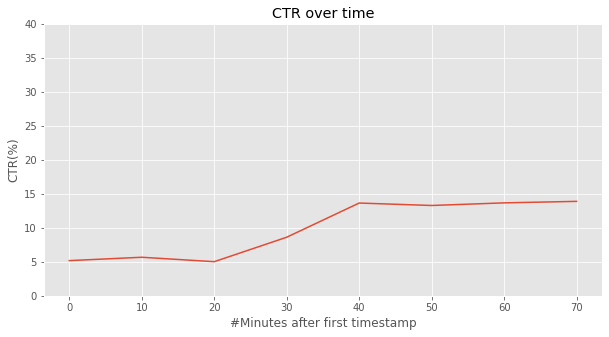

In [66]:
CTR_by_window(df_test_4, window_size=WINDOW_SIZE)

The evolution is quite identical and reach a CTR of 10,23% after filtering suspicious patterns.

## Conclusion 

3 suspicious patterns have been identified :

* Pattern 1 : ip with too much activities/uids
* Pattern 2 : uids with a high time reaction
* Pattern 3 : uids with more than 40 IP addresses == more than 15 clicks